In [1]:
import os
import warnings

os.environ['PYTHONWARNINGS'] = "ignore:Unverified HTTPS request"
warnings.filterwarnings("ignore")

import pandas as pd
import sqlite3
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from pandasql import sqldf
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
import random
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_auc_score, log_loss
from sklearn import metrics
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from scipy.stats import fisher_exact

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
### import data
df_master = pd.read_csv('burritos_01022018.csv', parse_dates=['Date'])

In [4]:
df_master.shape

(385, 66)

In [5]:
df_master.head(2)

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,2016-01-18,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.8,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,2016-01-24,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.0,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data understanding

Data contains following informations;

a) name, location, neighborhood, address, web page

b) order ingredients such as onion and pineapple  

c) consumer review and notes

Nan ratios are higher for speicf columns such as queso, zucchini, lobster

There is no missing value in Location, Burrito and Date column because its main keys for dataframe

In [6]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Location        385 non-null    object        
 1   Burrito         385 non-null    object        
 2   Date            385 non-null    datetime64[ns]
 3   Neighborhood    87 non-null     object        
 4   Address         83 non-null     object        
 5   URL             82 non-null     object        
 6   Yelp            82 non-null     float64       
 7   Google          82 non-null     float64       
 8   Chips           24 non-null     object        
 9   Cost            378 non-null    float64       
 10  Hunger          382 non-null    float64       
 11  Mass (g)        22 non-null     float64       
 12  Density (g/mL)  22 non-null     float64       
 13  Length          251 non-null    float64       
 14  Circum          249 non-null    float64       
 15  Volume

All null values are in yellow


Text(0.5, 1.0, 'Null Value Check')

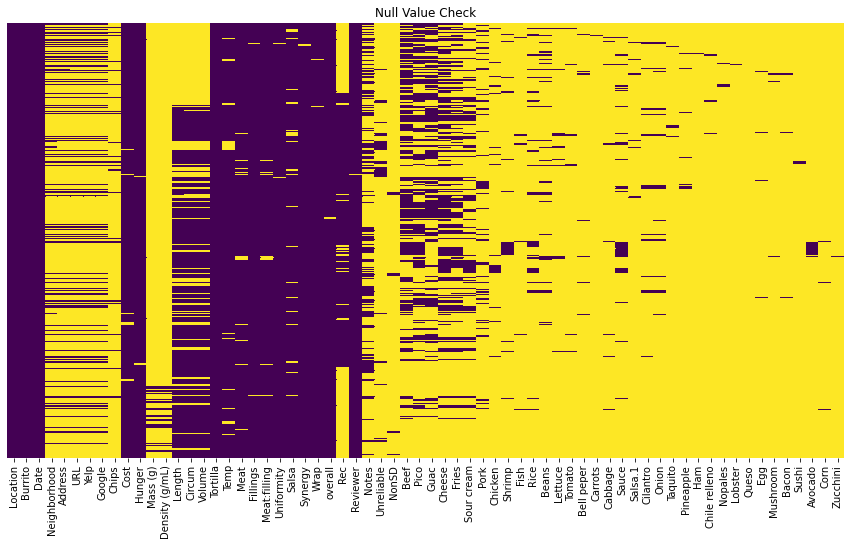

In [7]:
print('All null values are in yellow')
### Preapproval_Credit_Type is totally empty, it can be dropped from dataframe
### sequential horizontal yellow lines show that missing data in sequential columns, these record are analysed as below
plt.figure(figsize=(15,8))
sns.heatmap(data=df_master.isnull(), yticklabels=False, cbar= False, cmap='viridis')
plt.title('Null Value Check')

In [8]:
df_master.Location.nunique()

103

There are specific locations that have few orders so it cannot be meaningful to make predictions for these restaurants.

In [9]:
df_master.Location.value_counts(dropna=False)

Lucha Libre North Park                                 28
Rigoberto's Taco Shop                                  24
California Burritos                                    23
Taco Villa                                             19
Taco Stand                                             12
Taco stand                                             12
Los Tacos                                              12
Los Primos Mexican Food                                12
El Zarape                                               9
Vallarta express                                        9
Valentines Mexican Food                                 9
California burritos                                     6
Lupe's Taco Shop                                        6
Cancun Mexican & Seafood                                6
Lolita's taco shop                                      5
Roberto's Taco Shop Hillcrest                           5
California Burrito Company                              5
Burros and Fri

Burrito column has very poor data quality. The column represents the name of burritos for specific restaurants. Different restaurants could have used the same name for different products such as California. There is also empty spaces in strings of Burrito column unique values 

In [10]:
df_master.Burrito.nunique()

123

In [11]:
df_master[df_master.Location == "Oscar's Mexican food"]

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
1,Oscar's Mexican food,California,2016-01-24,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,2016-01-24,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,2016-01-24,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There is problematic rows related with upper or lower case letters for example Lolita's Taco shop

In [12]:
df_master[df_master['Location'].str.startswith("Lolita's Taco")]

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
120,Lolita's Taco shop,Carne asada,2016-05-27,NaN,NaN,NaN,NaN,NaN,NaN,6.25,4.0,NaN,NaN,15.0,20.5,0.50,1.5,2.5,3.0,4.5,4.0,2.0,2.75,3.75,3.0,2.6,No,Scott,Way too small,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,Lolita's Taco shop,Shrimp,2016-05-27,NaN,NaN,NaN,NaN,NaN,NaN,8.95,3.5,NaN,NaN,18.5,25.0,0.92,3.0,3.0,4.0,4.0,3.5,3.5,2.50,4.00,0.5,3.0,Yes,Emily,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,Lolita's Taco shop,Bean and cheese,2016-05-27,NaN,NaN,NaN,NaN,NaN,NaN,3.50,1.0,NaN,NaN,16.0,20.0,0.51,3.5,4.5,NaN,3.0,NaN,4.0,3.00,2.50,4.0,2.7,No,Scott,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,Lolita's Taco Shop,California,2016-06-23,NaN,NaN,NaN,NaN,NaN,NaN,7.00,2.2,NaN,NaN,18.0,25.0,0.90,2.8,3.0,3.0,2.0,2.0,4.5,2.00,1.50,4.5,2.3,No,Scott,NaN,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,Lolita's Taco Shop,California,2016-06-23,NaN,NaN,NaN,NaN,NaN,NaN,7.00,3.5,NaN,NaN,18.0,23.5,0.79,4.0,4.0,4.0,3.0,4.0,5.0,4.00,4.00,5.0,4.0,Yes,Cris,NaN,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,Lolita's Taco Shop,California,2016-06-23,NaN,NaN,NaN,NaN,NaN,NaN,7.00,3.0,NaN,NaN,19.0,24.0,0.87,3.5,2.0,3.0,4.0,2.0,4.0,3.00,3.00,4.0,3.0,NaN,Matt,NaN,NaN,NaN,x,NaN,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,Lolita's Taco Shop,Mixed,2016-06-23,NaN,NaN,NaN,NaN,NaN,NaN,8.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,5.0,3.00,4.00,5.0,3.5,Yes,Marc,NaN,NaN,NaN,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_master[df_master.Burrito.str.startswith('califo')].Burrito.value_counts(dropna=False)

Series([], Name: Burrito, dtype: int64)

In [14]:
df_master.Date.nunique()

152

Date columns have the maximum value of 2026-04-25 which is not possible. This value should be replaced with appropriate value. 

In [15]:
print(df_master.Date.min(), df_master.Date.max())

2011-05-16 00:00:00 2026-04-25 00:00:00


Neighborhood and Address columns are self explanatory

In [16]:
df_master.Neighborhood.nunique()

39

In [17]:
df_master.Address.nunique()

82

There is one row of neighborhood and address columns for each restaurant. By this way, data size can be kept smaller due to the huge amount of string.

In [18]:
df_master[df_master.Address == '9500 Gilman Dr']

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
193,Rubios UCSD,Tilapia one,2016-08-30,UTC,9500 Gilman Dr,https://www.yelp.com/biz/rubios-la-jolla-4,3.5,3.4,x,7.99,3.5,NaN,NaN,17.0,20.0,0.54,1.5,4.0,3.0,3.0,1.5,4.5,2.5,3.0,1.5,3.2,No,Scott,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,X,X,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN
240,Taco Villa,Carnitas,2016-09-26,UTC,9500 Gilman Dr,https://www.yelp.com/biz/taco-villa-san-diego,3.5,3.5,NaN,5.99,2.5,NaN,NaN,18.5,20.0,0.59,3.2,3.8,4.5,2.8,4.0,2.0,1.8,3.5,5.0,4.0,Yes,Scott,Carnitas very good,NaN,NaN,NaN,X,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_master.Address.value_counts()

9500 Gilman Dr                 2
642 S Coast Hwy 101            1
4370 Genessee Ave              1
4750 Oceanside Blvd            1
3202 Mission Blvd              1
Marshall College               1
4277 Genesee Ave               1
110 Washington St              1
3095 Clairemont Dr             1
1112 Morena Blvd               1
621 Pearl St                   1
524 Stevens Ave                1
582 Santa Fe Dr                1
377 Carlsbad Village Dr        1
5060 Newport Ave               1
4646 Convoy St                 1
Airport                        1
745 Emerald St                 1
6780 Miramar Rd                1
3695 India St                  1
2206 Carmel Valley Road        1
4471 Clairemont Mesa Blvd      1
1313 Garnet Ave                1
267 N El Camino Real           1
2113 San Elijo Ave             1
5059 Federal Blvd              1
3055 Harding St                1
1408 Olympic Blvd              1
290 N Coast Hwy 101            1
249 Emerald Dr                 1
7122 Miram

There is one row of neighborhood,address and URL columns for each restaurant. This can be acceptable because data size can be kept smaller by this way rather than replicated those values for each restaurant

There is a problem with some locations that have no address and url page values. This can be acceptable if these restaurants accept orders by only phone. Let’s check

Taco stand restaurant is one example that doesn’t have specific neighborhood, address and url information. This information can be updated by using google. In addition, this restaurant has a date value of 2026-04-25. This is not possible. 


In [20]:
df_master.groupby('Location')['Address'].nunique().reset_index()

,Location,Address
0,Albertacos,1
1,"Alberto's 623 N Escondido Blvd, Escondido, CA ...",0
2,Burrito Box,0
3,Burrito Factory,1
4,Burros and Fries,1
5,Caliente Mexican Food,1
6,California Burrito Company,1
7,California Burritos,1
8,California burritos,0
9,Cancun Mexican & Seafood,1


In [21]:
df_master[df_master.Location == 'Taco stand']

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
39,Taco stand,Carne asada,2016-03-18,NaN,NaN,NaN,NaN,NaN,NaN,7.89,1.0,NaN,NaN,NaN,NaN,NaN,3.0,3.5,4.5,4.0,5.0,5.0,4.5,3.5,5.0,4.2,NaN,Scott,NaN,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Taco stand,Al pastor,2016-03-18,NaN,NaN,NaN,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.5,3.0,4.0,5.0,3.0,3.5,5.0,3.5,NaN,Emily,Kind of dry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,x,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,Taco stand,Carne asada,2016-04-14,NaN,NaN,NaN,NaN,NaN,NaN,7.89,3.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,4.5,4.0,4.0,1.5,4.5,4.5,4.5,4.4,Yes,Scott,Too small,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,Taco stand,Carne asada,2016-04-14,NaN,NaN,NaN,NaN,NaN,NaN,7.89,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.5,4.5,3.5,4.5,3.0,4.0,3.5,5.0,3.5,Yes,Richard,A little small. No rice and beans or cheese or...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,Taco stand,California,2026-04-25,NaN,NaN,NaN,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,4.9,Yes,Sage,A wonderful eating experience. best California...,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,Taco stand,California,2016-05-06,NaN,NaN,NaN,NaN,NaN,NaN,7.49,3.5,NaN,NaN,19.00,22.0,0.73,3.5,4.0,4.0,4.0,3.5,3.0,4.0,4.5,3.0,4.2,Yes,Scott,Less meat than usual,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Taco stand,California,2016-05-06,NaN,NaN,NaN,NaN,NaN,NaN,7.49,4.0,NaN,NaN,16.50,25.0,0.82,4.0,3.5,4.0,4.0,4.5,5.0,4.5,5.0,4.5,4.5,Yes,Ricardo,NaN,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Taco stand,California,2016-05-06,NaN,NaN,NaN,NaN,NaN,NaN,7.49,4.0,NaN,NaN,17.00,25.5,0.88,3.0,3.0,4.0,3.5,3.5,4.0,3.5,4.0,2.5,3.7,Yes,Luis,NaN,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Taco stand,California,2016-05-06,NaN,NaN,NaN,NaN,NaN,NaN,7.49,3.0,NaN,NaN,17.70,21.5,0.65,4.0,2.0,5.0,5.0,1.0,3.0,5.0,4.0,3.0,4.0,Yes,Elynn,NaN,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Taco stand,California,2016-05-06,NaN,NaN,NaN,NaN,NaN,NaN,7.49,1.0,NaN,NaN,20.00,23.5,0.88,4.0,3.0,4.0,4.5,5.0,4.5,3.0,4.5,4.0,4.0,Yes,Sandra,NaN,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_master.Yelp.value_counts()

4.0    40
4.5    17
3.5    16
3.0     6
2.5     2
4.2     1
Name: Yelp, dtype: int64

Yelp points weren't distributed normally. There is left skewness in data. Some locations don’t have yelp points. 

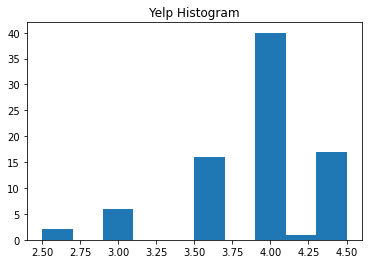

In [23]:
plt.hist(df_master.Yelp)
plt.title("Yelp Histogram") 

plt.show()

Most of the review points are between 3.5 and 4. Most successful ones are around 4.5 

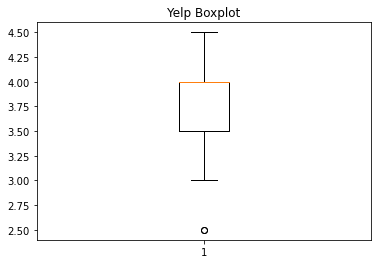

In [24]:
plt.boxplot(df_master[(~df_master.Yelp.isna())]['Yelp'])
plt.title("Yelp Boxplot") 
plt.show()

In [25]:
df_master.groupby('Location')['Yelp'].nunique().reset_index()

,Location,Yelp
0,Albertacos,1
1,"Alberto's 623 N Escondido Blvd, Escondido, CA ...",0
2,Burrito Box,0
3,Burrito Factory,1
4,Burros and Fries,1
5,Caliente Mexican Food,1
6,California Burrito Company,1
7,California Burritos,1
8,California burritos,0
9,Cancun Mexican & Seafood,1


Google reviews include more sensitive data.

In [26]:
df_master.Google.unique()

array([4.2, 3.3, nan, 3.8, 2.9, 3.7, 4.1, 4.4, 4.5, 4. , 4.9, 3.9, 4.7,
       4.3, 4.6, 3.4, 3.5, 5. , 4.8])

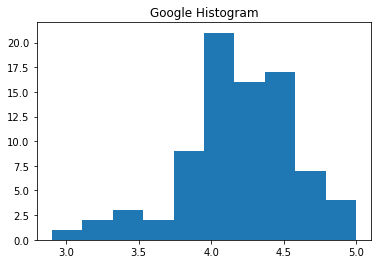

In [27]:
plt.hist(df_master.Google)
plt.title("Google Histogram") 

plt.show()

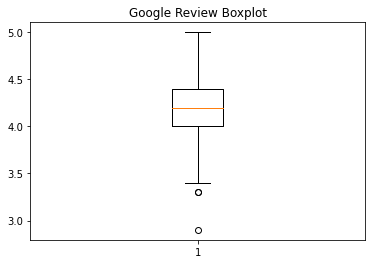

In [28]:
plt.boxplot(df_master[(~df_master.Google.isna())]['Google'])
plt.title("Google Review Boxplot") 
plt.show()

upper and lower case

In [29]:
df_master.Chips.unique()

array([nan, 'x', 'X'], dtype=object)

In [30]:
df_master.Chips.value_counts()

x    21
X     3
Name: Chips, dtype: int64

Cost data seems to be normal but there is outlier values at tails 

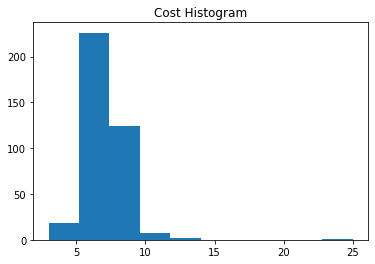

In [31]:
plt.hist(df_master.Cost)
plt.title("Cost Histogram") 
plt.show()

It isn’t clear the cost represent unit cost or total cost 

As seen, NaN ratio on age is 1.8%. Let's look at the boxplot and distribution without NaN

In [32]:
df_master.Cost.value_counts(normalize=True,dropna=False)

6.25     0.106494
6.99     0.057143
7.90     0.044156
8.25     0.044156
7.00     0.041558
7.50     0.041558
6.60     0.038961
7.49     0.038961
5.99     0.038961
6.50     0.036364
7.89     0.023377
6.85     0.020779
6.95     0.020779
5.50     0.018182
NaN      0.018182
8.50     0.015584
4.99     0.015584
6.39     0.012987
6.75     0.012987
6.00     0.012987
6.49     0.010390
8.75     0.010390
7.75     0.010390
5.25     0.010390
7.35     0.007792
5.56     0.007792
6.89     0.007792
7.99     0.007792
7.19     0.007792
7.65     0.007792
8.00     0.007792
5.95     0.007792
6.35     0.007792
9.50     0.007792
9.00     0.007792
8.59     0.005195
5.79     0.005195
4.87     0.005195
7.25     0.005195
7.10     0.005195
5.00     0.005195
5.55     0.005195
6.47     0.005195
6.65     0.005195
6.40     0.005195
6.94     0.005195
9.25     0.005195
10.00    0.005195
5.49     0.005195
7.14     0.005195
8.95     0.005195
11.95    0.005195
7.95     0.005195
7.40     0.005195
5.69     0.005195
7.29     0

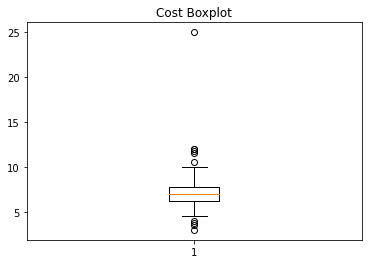

In [33]:
plt.boxplot(df_master[(~df_master.Cost.isna())]['Cost'])
plt.title("Cost Boxplot") 
plt.show()

Boxplot shows that we have few outliers. However, the distribution converges to normal. Most of the the data lies between 5-15 anyways so let's see how is the distribution between cost of 5 and 15.

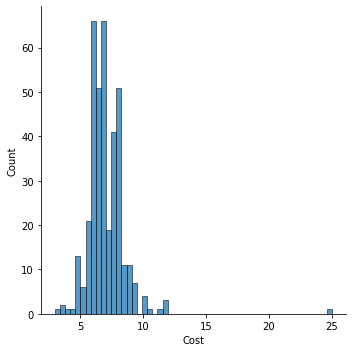

In [34]:
sns.displot(df_master[(~df_master.Cost.isna())]['Cost'])
plt.show()

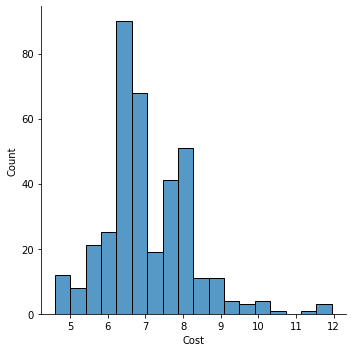

In [35]:
sns.displot(df_master[(~df_master.Cost.isna()) & (df_master.Cost>4) & (df_master.Cost<15)]['Cost'])
plt.show()

Finally we have smoother distribution on data. It contains 96% percent of all data.

In [36]:
len(df_master[(~df_master.Cost.isna()) & (df_master.Cost>4) & (df_master.Cost<15)]['Cost'])/len(df_master)

0.9688311688311688

Now, let's deal with the quantity and price, let's check whether the price is for total quantity (like multiplied quantity by unit price) or directly unit price

It seems that cost represents the unit price of the order but there is difference between fractions of price

In [37]:
df_master[(df_master.Location == 'Taco Villa') & (df_master.Burrito == 'Carnitas')]

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
240,Taco Villa,Carnitas,2016-09-26,UTC,9500 Gilman Dr,https://www.yelp.com/biz/taco-villa-san-diego,3.5,3.5,NaN,5.99,2.5,NaN,NaN,18.5,20.0,0.59,3.2,3.8,4.5,2.8,4.0,2.0,1.8,3.5,5.0,4.0,Yes,Scott,Carnitas very good,NaN,NaN,NaN,X,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,Taco Villa,Carnitas,2016-10-27,NaN,NaN,NaN,NaN,NaN,NaN,5.95,3.0,NaN,NaN,18.0,20.0,0.57,4.0,3.0,4.0,3.0,4.0,2.0,3.5,3.0,5.0,3.9,Yes,Scott,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,Taco Villa,Carnitas,2017-04-25,NaN,NaN,NaN,NaN,NaN,NaN,5.99,4.0,450.0,0.703125,20.0,20.0,0.64,2.0,4.5,4.5,3.0,3.8,4.4,2.5,3.5,3.0,4.0,NaN,Scott,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,Taco Villa,Carnitas,2017-04-25,NaN,NaN,NaN,NaN,NaN,NaN,5.99,4.0,NaN,NaN,18.5,20.0,0.59,4.0,4.0,4.0,3.0,4.0,3.5,2.5,3.5,5.0,3.5,NaN,Richard,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
376,Taco Villa,Carnitas,2017-08-25,NaN,NaN,NaN,NaN,NaN,NaN,5.99,2.0,NaN,NaN,20.0,21.5,0.74,2.0,2.5,4.0,3.0,4.0,3.5,3.0,3.0,5.0,3.8,NaN,Scott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets found the amount of order for each day 

In [38]:
df_master.groupby('Date')['Cost'].agg('sum').reset_index().sort_values(by='Cost', ascending=False)

,Date,Cost
76,2016-08-30,220.44
65,2016-06-24,55.50
37,2016-05-06,54.29
40,2016-05-13,46.20
32,2016-04-15,44.65
66,2016-08-01,44.50
24,2016-03-21,42.30
56,2016-06-03,40.85
102,2016-11-16,38.35
122,2017-04-07,37.75


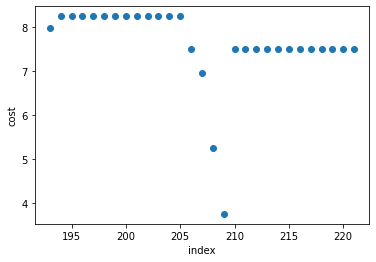

In [39]:
plt.scatter(df_master[df_master.Date == '2016-08-30'].index, df_master[df_master.Date == '2016-08-30'].Cost)
plt.xlabel("index")
plt.ylabel("cost")
plt.show()

Let’s define a function in order to plot multiple column information by one click

In [40]:
def get_column_information(df, i):
    print('-'*80)
    print('Column : ' + i)
    print(f'Null ratios of column {i}: ' + str(len(df[(~df[i].isna())][i])/len(df)))
    sns.displot(df[(~df[i].isna())][i])
    plt.show()
    print('Number of unique values: ' + str(df[i].nunique()))
    print(df[i].value_counts(normalize=True,dropna=False))
    plt.boxplot(df[(~df[i].isna())][i])
    plt.title(f'{i} Boxplot') 
    plt.show()

In [41]:
column_list = ['Hunger','Mass (g)','Density (g/mL)','Length','Circum','Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']

--------------------------------------------------------------------------------
Column : Hunger
Null ratios of column Hunger: 0.9922077922077922


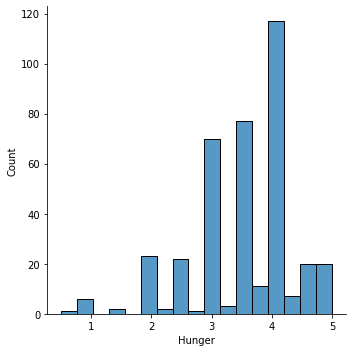

Number of unique values: 26
4.00    0.296104
3.50    0.200000
3.00    0.181818
2.00    0.059740
2.50    0.057143
4.50    0.051948
5.00    0.049351
1.00    0.015584
4.30    0.010390
3.80    0.007792
3.75    0.007792
NaN     0.007792
3.70    0.007792
1.50    0.005195
4.20    0.005195
3.90    0.005195
3.20    0.005195
4.25    0.002597
2.30    0.002597
4.75    0.002597
2.80    0.002597
2.20    0.002597
3.30    0.002597
4.40    0.002597
4.31    0.002597
0.50    0.002597
4.10    0.002597
Name: Hunger, dtype: float64


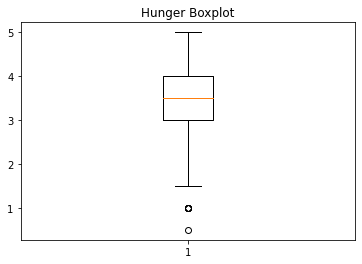

--------------------------------------------------------------------------------
Column : Mass (g)
Null ratios of column Mass (g): 0.05714285714285714


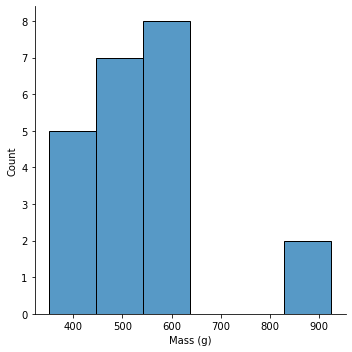

Number of unique values: 18
NaN      0.942857
450.0    0.007792
540.0    0.005195
550.0    0.005195
520.0    0.002597
620.0    0.002597
920.0    0.002597
635.0    0.002597
476.0    0.002597
610.0    0.002597
600.0    0.002597
560.0    0.002597
350.0    0.002597
425.0    0.002597
430.0    0.002597
580.0    0.002597
925.0    0.002597
420.0    0.002597
415.0    0.002597
Name: Mass (g), dtype: float64


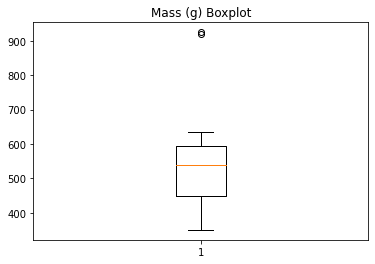

--------------------------------------------------------------------------------
Column : Density (g/mL)
Null ratios of column Density (g/mL): 0.05714285714285714


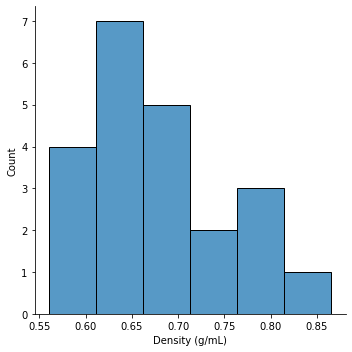

Number of unique values: 21
NaN         0.942857
0.625000    0.005195
0.617647    0.002597
0.683544    0.002597
0.744681    0.002597
0.865672    0.002597
0.600649    0.002597
0.613636    0.002597
0.703125    0.002597
0.785714    0.002597
0.708333    0.002597
0.565657    0.002597
0.726190    0.002597
0.687500    0.002597
0.560000    0.002597
0.597403    0.002597
0.632353    0.002597
0.626506    0.002597
0.783951    0.002597
0.632653    0.002597
0.779221    0.002597
0.691667    0.002597
Name: Density (g/mL), dtype: float64


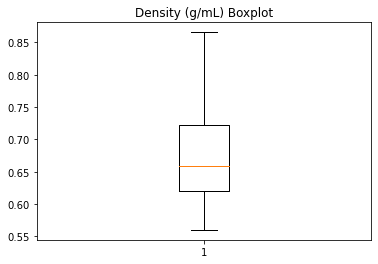

--------------------------------------------------------------------------------
Column : Length
Null ratios of column Length: 0.6519480519480519


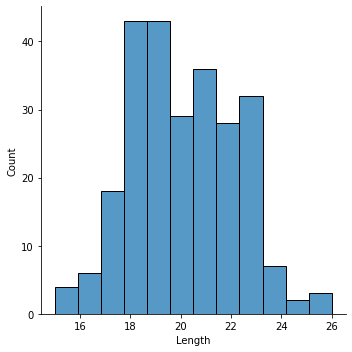

Number of unique values: 29
NaN      0.348052
20.00    0.075325
19.00    0.062338
18.50    0.057143
18.00    0.051948
19.50    0.049351
21.00    0.044156
20.50    0.044156
23.00    0.041558
22.50    0.041558
22.00    0.036364
21.50    0.031169
17.00    0.025974
17.50    0.018182
16.50    0.012987
23.50    0.012987
25.50    0.005195
24.00    0.005195
15.50    0.005195
15.00    0.005195
25.00    0.002597
24.50    0.002597
21.30    0.002597
16.00    0.002597
17.78    0.002597
22.20    0.002597
21.59    0.002597
26.00    0.002597
17.70    0.002597
20.75    0.002597
Name: Length, dtype: float64


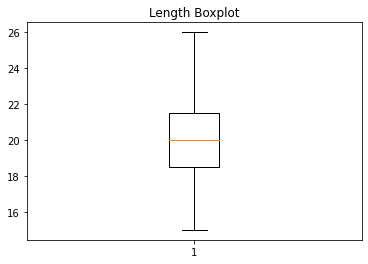

--------------------------------------------------------------------------------
Column : Circum
Null ratios of column Circum: 0.6467532467532467


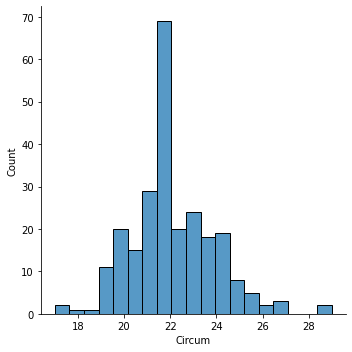

Number of unique values: 28
NaN       0.353247
22.000    0.096104
21.500    0.080519
21.000    0.070130
23.000    0.059740
20.000    0.051948
22.500    0.046753
23.500    0.044156
20.500    0.038961
24.000    0.031169
25.000    0.020779
24.500    0.018182
19.500    0.015584
25.500    0.012987
19.000    0.012987
29.000    0.005195
26.500    0.005195
26.000    0.005195
17.000    0.005195
21.750    0.002597
18.000    0.002597
23.800    0.002597
21.200    0.002597
20.800    0.002597
22.225    0.002597
22.125    0.002597
18.500    0.002597
22.750    0.002597
27.000    0.002597
Name: Circum, dtype: float64


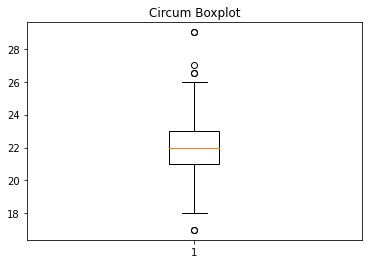

--------------------------------------------------------------------------------
Column : Volume
Null ratios of column Volume: 0.6467532467532467


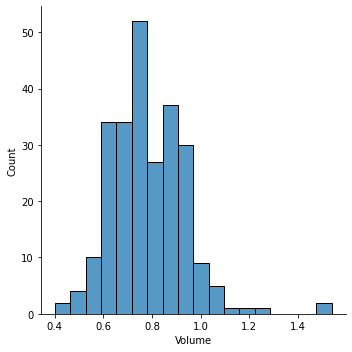

Number of unique values: 62
NaN     0.353247
0.65    0.041558
0.77    0.041558
0.75    0.033766
0.68    0.031169
0.85    0.028571
0.72    0.023377
0.70    0.020779
0.74    0.020779
0.83    0.018182
0.87    0.018182
0.96    0.015584
0.60    0.015584
0.92    0.015584
0.88    0.015584
0.93    0.015584
0.64    0.015584
0.84    0.012987
0.73    0.012987
0.89    0.012987
0.79    0.012987
0.67    0.010390
0.94    0.010390
0.81    0.010390
0.86    0.010390
0.66    0.010390
0.69    0.010390
0.90    0.010390
0.99    0.007792
0.95    0.007792
0.62    0.007792
1.01    0.007792
0.57    0.007792
0.91    0.007792
0.80    0.007792
1.09    0.005195
0.54    0.005195
0.63    0.005195
1.54    0.005195
0.97    0.005195
0.82    0.005195
0.71    0.005195
0.59    0.005195
0.51    0.005195
1.07    0.002597
1.24    0.002597
0.50    0.002597
0.76    0.002597
0.47    0.002597
0.58    0.002597
0.40    0.002597
1.17    0.002597
1.00    0.002597
0.55    0.002597
1.03    0.002597
1.05    0.002597
0.98    0.002597
1.0

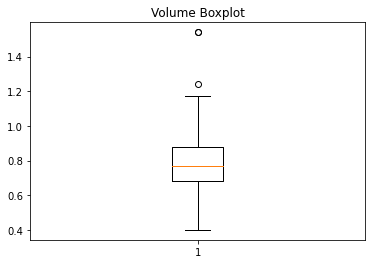

--------------------------------------------------------------------------------
Column : Tortilla
Null ratios of column Tortilla: 1.0


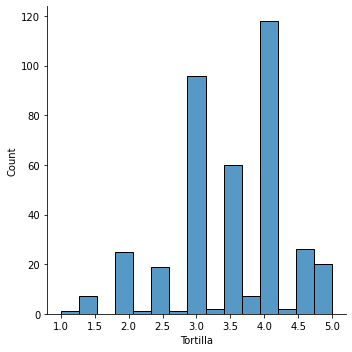

Number of unique values: 18
4.00    0.306494
3.00    0.249351
3.50    0.150649
4.50    0.067532
2.00    0.064935
5.00    0.049351
2.50    0.049351
1.50    0.015584
3.80    0.015584
4.20    0.005195
3.60    0.005195
3.20    0.005195
2.80    0.002597
1.40    0.002597
3.75    0.002597
1.00    0.002597
4.80    0.002597
2.10    0.002597
Name: Tortilla, dtype: float64


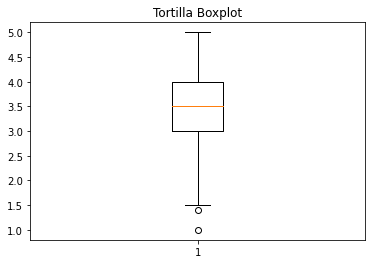

--------------------------------------------------------------------------------
Column : Temp
Null ratios of column Temp: 0.948051948051948


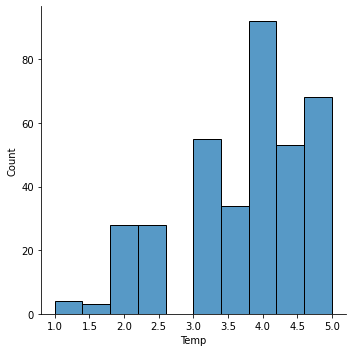

Number of unique values: 18
4.0    0.238961
5.0    0.171429
3.0    0.140260
4.5    0.129870
3.5    0.075325
2.5    0.072727
2.0    0.070130
NaN    0.051948
1.0    0.007792
3.8    0.007792
1.5    0.007792
4.7    0.005195
4.4    0.005195
3.6    0.002597
1.9    0.002597
3.7    0.002597
1.3    0.002597
4.2    0.002597
3.2    0.002597
Name: Temp, dtype: float64


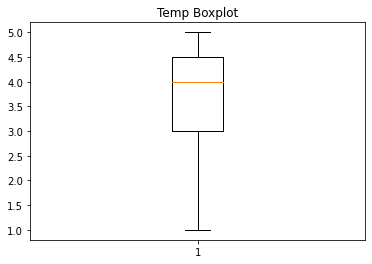

--------------------------------------------------------------------------------
Column : Meat
Null ratios of column Meat: 0.9688311688311688


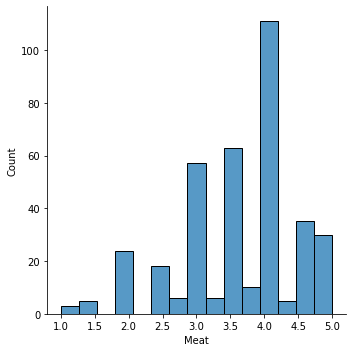

Number of unique values: 23
4.00    0.285714
3.50    0.163636
3.00    0.148052
4.50    0.088312
5.00    0.077922
2.00    0.062338
2.50    0.046753
NaN     0.031169
1.50    0.012987
4.20    0.010390
3.30    0.010390
3.80    0.010390
1.00    0.007792
3.70    0.007792
3.20    0.005195
2.75    0.005195
2.60    0.005195
3.75    0.005195
2.70    0.002597
2.80    0.002597
4.70    0.002597
3.90    0.002597
4.10    0.002597
4.30    0.002597
Name: Meat, dtype: float64


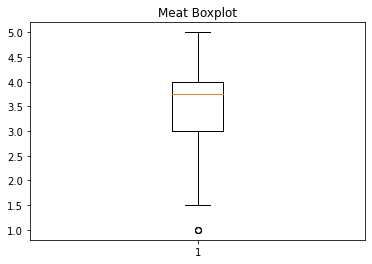

--------------------------------------------------------------------------------
Column : Fillings
Null ratios of column Fillings: 0.9948051948051948


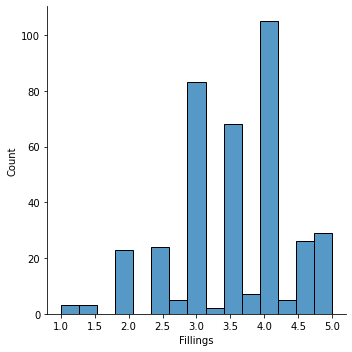

Number of unique values: 22
4.00    0.272727
3.00    0.215584
3.50    0.171429
5.00    0.075325
4.50    0.062338
2.00    0.059740
2.50    0.057143
3.80    0.015584
2.80    0.010390
1.50    0.007792
1.00    0.007792
2.40    0.005195
NaN     0.005195
4.70    0.005195
4.20    0.005195
4.30    0.005195
3.40    0.002597
3.70    0.002597
3.30    0.002597
4.40    0.002597
3.60    0.002597
2.75    0.002597
3.20    0.002597
Name: Fillings, dtype: float64


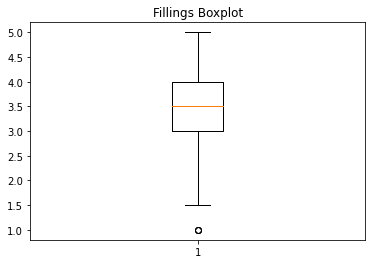

--------------------------------------------------------------------------------
Column : Meat:filling
Null ratios of column Meat:filling: 0.9792207792207792


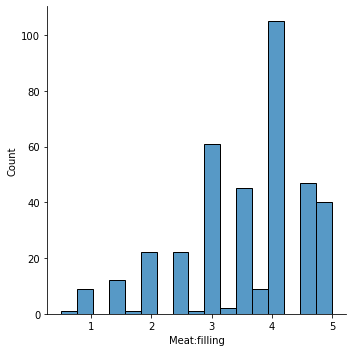

Number of unique values: 25
4.00    0.267532
3.00    0.153247
4.50    0.114286
3.50    0.114286
5.00    0.098701
2.50    0.057143
2.00    0.057143
1.50    0.028571
1.00    0.023377
NaN     0.020779
3.70    0.007792
4.70    0.007792
3.75    0.007792
3.80    0.005195
2.90    0.005195
4.20    0.005195
4.80    0.002597
0.50    0.002597
3.60    0.002597
3.78    0.002597
1.80    0.002597
1.40    0.002597
3.40    0.002597
4.75    0.002597
2.80    0.002597
3.20    0.002597
Name: Meat:filling, dtype: float64


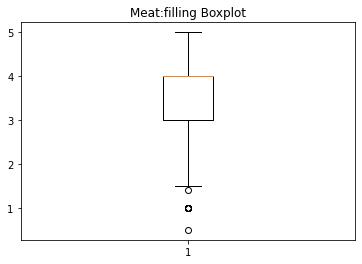

--------------------------------------------------------------------------------
Column : Uniformity
Null ratios of column Uniformity: 0.9948051948051948


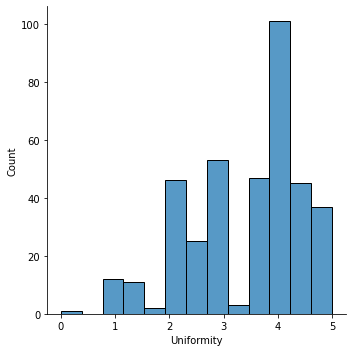

Number of unique values: 27
4.00    0.259740
3.00    0.129870
3.50    0.116883
2.00    0.114286
4.50    0.106494
5.00    0.093506
2.50    0.059740
1.00    0.031169
1.50    0.028571
2.40    0.005195
NaN     0.005195
2.80    0.005195
4.40    0.005195
2.30    0.002597
1.60    0.002597
3.20    0.002597
4.20    0.002597
2.70    0.002597
3.80    0.002597
1.80    0.002597
3.10    0.002597
3.30    0.002597
3.70    0.002597
2.20    0.002597
4.60    0.002597
0.00    0.002597
4.75    0.002597
4.30    0.002597
Name: Uniformity, dtype: float64


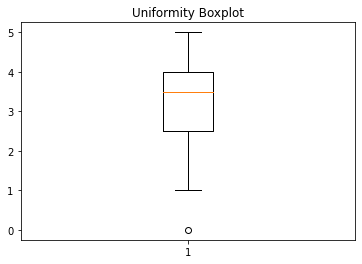

--------------------------------------------------------------------------------
Column : Salsa
Null ratios of column Salsa: 0.9428571428571428


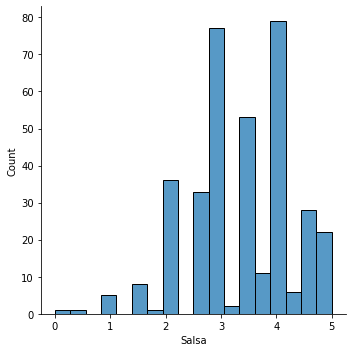

Number of unique values: 26
4.00    0.200000
3.00    0.197403
3.50    0.135065
2.00    0.090909
2.50    0.083117
4.50    0.072727
NaN     0.057143
5.00    0.051948
1.50    0.020779
3.80    0.015584
1.00    0.012987
4.30    0.007792
3.70    0.007792
4.20    0.007792
3.75    0.005195
3.90    0.005195
4.75    0.002597
0.00    0.002597
3.30    0.002597
2.20    0.002597
1.80    0.002597
0.50    0.002597
4.80    0.002597
3.60    0.002597
2.75    0.002597
3.20    0.002597
2.90    0.002597
Name: Salsa, dtype: float64


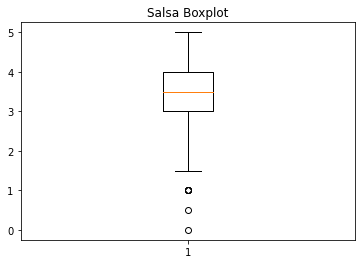

--------------------------------------------------------------------------------
Column : Synergy
Null ratios of column Synergy: 0.9948051948051948


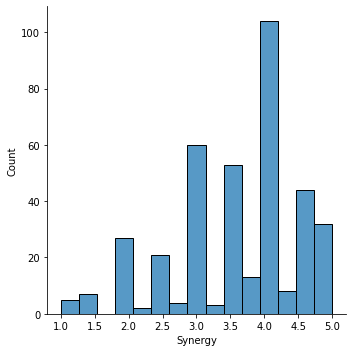

Number of unique values: 27
4.00    0.270130
3.00    0.150649
3.50    0.135065
4.50    0.106494
5.00    0.075325
2.00    0.070130
2.50    0.054545
3.80    0.018182
1.50    0.018182
1.00    0.012987
4.30    0.010390
3.70    0.007792
3.75    0.007792
2.80    0.007792
4.20    0.007792
4.80    0.005195
3.30    0.005195
NaN     0.005195
2.90    0.005195
4.70    0.005195
3.40    0.002597
2.30    0.002597
2.20    0.002597
2.70    0.002597
4.40    0.002597
3.20    0.002597
4.90    0.002597
4.60    0.002597
Name: Synergy, dtype: float64


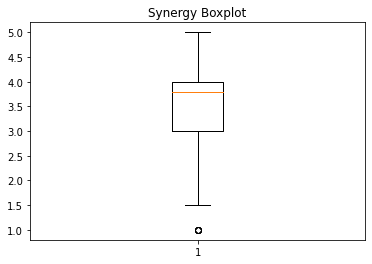

--------------------------------------------------------------------------------
Column : Wrap
Null ratios of column Wrap: 0.9948051948051948


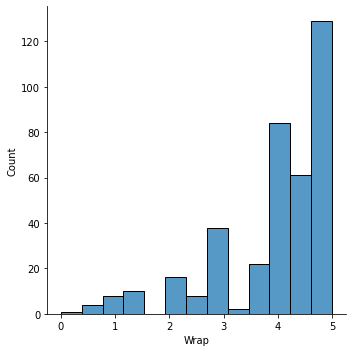

Number of unique values: 22
5.0    0.327273
4.0    0.212987
4.5    0.155844
3.0    0.098701
3.5    0.049351
2.0    0.038961
1.5    0.023377
1.0    0.020779
2.5    0.018182
0.5    0.010390
4.8    0.007792
3.8    0.005195
NaN    0.005195
2.6    0.002597
0.0    0.002597
3.3    0.002597
3.4    0.002597
3.7    0.002597
2.2    0.002597
3.9    0.002597
4.2    0.002597
1.2    0.002597
4.3    0.002597
Name: Wrap, dtype: float64


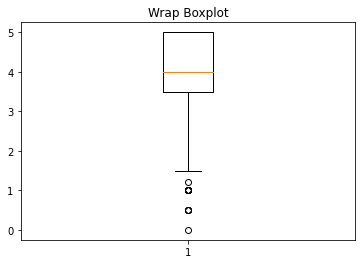

--------------------------------------------------------------------------------
Column : overall
Null ratios of column overall: 0.9948051948051948


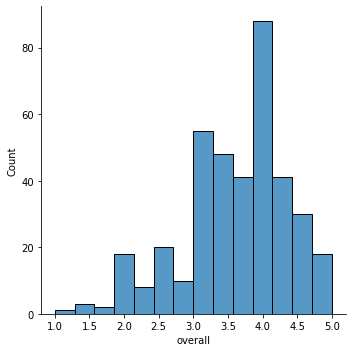

Number of unique values: 39
4.00000    0.163636
3.50000    0.103896
3.00000    0.098701
4.20000    0.059740
4.50000    0.059740
2.00000    0.046753
3.90000    0.041558
3.70000    0.036364
3.80000    0.033766
5.00000    0.028571
3.20000    0.025974
4.10000    0.023377
2.50000    0.023377
3.60000    0.020779
4.25000    0.018182
4.30000    0.018182
3.75000    0.015584
2.60000    0.015584
4.80000    0.012987
3.10000    0.012987
2.20000    0.010390
2.70000    0.010390
4.40000    0.010390
3.30000    0.010390
4.70000    0.010390
2.80000    0.010390
2.90000    0.010390
3.40000    0.007792
4.60000    0.007792
1.50000    0.007792
4.90000    0.005195
2.75000    0.005195
3.25000    0.005195
NaN        0.005195
1.80000    0.005195
2.40000    0.005195
2.30000    0.005195
3.33333    0.002597
2.66000    0.002597
1.00000    0.002597
Name: overall, dtype: float64


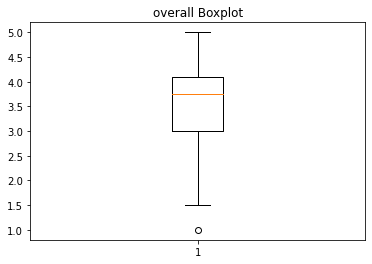

In [42]:
for i in column_list:
    get_column_information(df_master, i)

In [43]:
df_master.Notes.nunique()

128

In [44]:
df_master.Notes.value_counts()

Bland                                                                                                                                                                                2
It's pretty good for what it is, but just not the best ingredients for a burrito. also Few white people                                                                              1
Rice was plain. Also don't like rice in burrito                                                                                                                                      1
A bit small                                                                                                                                                                          1
feels very dense; a lot of meat                                                                                                                                                      1
it does taste homemade. but that's not a good thing                                  

In [45]:
column_list = list(df_master.columns)
for i in column_list[29:]:
    print('-'*20)
    print('Column :' + i)
    print(df_master[i].value_counts(normalize=True, dropna=False))

--------------------
Column :Unreliable
NaN    0.922078
x      0.077922
Name: Unreliable, dtype: float64
--------------------
Column :NonSD
NaN    0.981818
x      0.012987
X      0.005195
Name: NonSD, dtype: float64
--------------------
Column :Beef
NaN    0.542857
x      0.348052
X      0.109091
Name: Beef, dtype: float64
--------------------
Column :Pico
NaN    0.605195
x      0.314286
X      0.080519
Name: Pico, dtype: float64
--------------------
Column :Guac
NaN    0.618182
x      0.277922
X      0.103896
Name: Guac, dtype: float64
--------------------
Column :Cheese
NaN    0.597403
x      0.322078
X      0.080519
Name: Cheese, dtype: float64
--------------------
Column :Fries
NaN    0.675325
x      0.259740
X      0.064935
Name: Fries, dtype: float64
--------------------
Column :Sour cream
NaN    0.768831
x      0.166234
X      0.064935
Name: Sour cream, dtype: float64
--------------------
Column :Pork
NaN    0.877922
x      0.083117
X      0.038961
Name: Pork, dtype: float64
---

In [46]:
df_daily_cost = df_master.groupby('Date').agg({'Cost':['mean', 'std','sum'],
                                            'Burrito':'count',
                                            'Hunger':['mean', 'std','sum']})

df_daily_cost.columns = df_daily_cost.columns.droplevel(0)

df_daily_cost = df_daily_cost.reset_index().rename_axis(None, axis=1)
df_daily_cost.columns = ['date', 'Cost_mean', 'Cost_std', 'Cost_sum', 
                         'order_count', 'Hunger_mean', 'Hunger_std', 'Hunger_sum']

df_daily_cost.sort_values(by='date', ascending=True, inplace=True)

df_daily_cost[['Cost_mean', 'Hunger_mean']] = df_daily_cost[['Cost_mean', 'Hunger_mean']].fillna(value=0)

trace = go.Scatter(
    x = df_daily_cost['date'].values,
    y = df_daily_cost['Cost_mean'].values,
    mode='markers',
    marker=dict(
        size = df_daily_cost['Cost_mean'],
        color = df_daily_cost['Cost_mean'],
        colorscale='Portland',
        showscale=True
    )
)
layout= go.Layout(
    autosize= True,
    title= 'Daily mean order amount',
    hovermode= 'closest',
    xaxis=dict(
        title= 'Date',
        ticklen= 5,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Cost_mean',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=trace, layout=layout)
fig

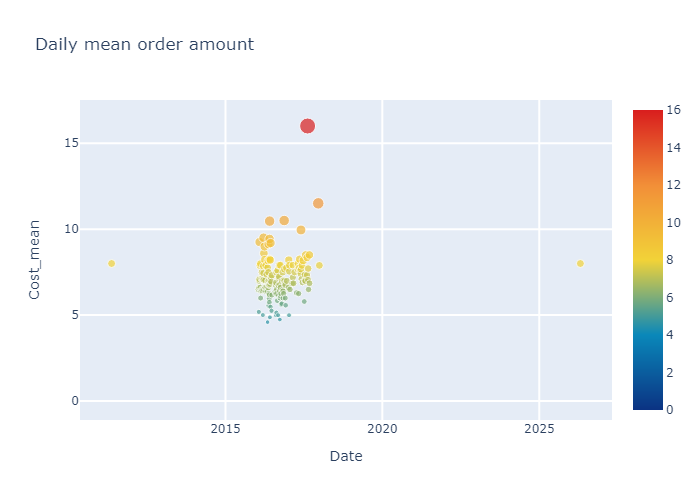

In [47]:
fig.show(renderer="png")

### Enhancement 1

convert strings to lower case

In [48]:
df_master[df_master['Location'].str.startswith("L")].Location.value_counts().sort_index()

La Morena Taco Shop and Seafood     1
La Perla Cocina                     3
Lola's 7 Up Market & Deli           2
Lolita's                            1
Lolita's Taco Shop                  4
Lolita's Taco shop                  3
Lolita's taco shop                  5
Los Cabos                           2
Los Panchos Taco Shop               3
Los Primos Mexican Food            12
Los Tacos                          12
Los Tacos 2                         4
Los palmitos                        2
Los tacos                           2
Lourdes                             2
Lucha Libre North Park             28
Lupe's Taco Shop                    6
Name: Location, dtype: int64

In [49]:
df_master = df_master.apply(lambda x: x.str.lower() if x.dtype == "object" else x) 

In [50]:
df_master[df_master['Location'].str.startswith("l")].Location.value_counts().sort_index()

la morena taco shop and seafood     1
la perla cocina                     3
lola's 7 up market & deli           2
lolita's                            1
lolita's taco shop                 12
los cabos                           2
los palmitos                        2
los panchos taco shop               3
los primos mexican food            12
los tacos                          12
los tacos                           2
los tacos 2                         4
lourdes                             2
lucha libre north park             28
lupe's taco shop                    6
Name: Location, dtype: int64

### Enhancement 2

change the location of the chip column. It should be with columns that represent the ingredients 

In [51]:
cols = list(df_master.columns)
cols.pop(cols.index('Chips'))
df_master = df_master[cols + ['Chips']] 

In [52]:
df_master.shape

(385, 66)

### Enhancement 3

remove blank space at the end of string 

In [53]:
df_master[df_master.Burrito.str.startswith('califo')].Burrito.value_counts(dropna=False)

california                        91
california                        26
california everything             17
california - pork adobada          3
california - chicken               2
california chicken                 2
california - steak                 2
california everything mini         1
california surf and turf           1
california burrito                 1
california breakfast               1
california surf                    1
california chipotle                1
california + guac + sour cream     1
california (only cheese)           1
Name: Burrito, dtype: int64

In [54]:
df_master = df_master.apply(lambda x: x.str.rstrip() if x.dtype == "object" else x) 

In [55]:
df_master[df_master.Burrito.str.startswith('califo')].Burrito.value_counts(dropna=False)

california                        117
california everything              17
california - pork adobada           3
california - chicken                2
california chicken                  2
california - steak                  2
california everything mini          1
california surf and turf            1
california burrito                  1
california breakfast                1
california chipotle                 1
california surf                     1
california + guac + sour cream      1
california (only cheese)            1
Name: Burrito, dtype: int64

### Enhancement 4

I will remove punctuation marks at the end of the string. I checked from google that ‘kotija jr’ and ‘kotija jr.’ represents the same restaurant 

In [56]:
df_master[df_master.Location.str.startswith('kotija')].Location.value_counts(dropna=False)

kotija jr     2
kotija jr.    1
Name: Location, dtype: int64

In [57]:
df_master = df_master.apply(lambda x: x.str.rstrip('.') if x.dtype == "object" else x) 

In [58]:
df_master[df_master.Location.str.startswith('kotija')].Location.value_counts(dropna=False)

kotija jr    3
Name: Location, dtype: int64

### Enhancement 5

After searching from google, I couldn’t find the restaurant name, just colima's. I think there is missing words for those records so that I will repaled those with colima's mexican food
Moreover, same situation is applicable to  lolita's and lolita's taco shop


In [59]:
df_master[df_master.Location.str.startswith("lolita's")].Location.value_counts(dropna=False)

lolita's taco shop    12
lolita's               1
Name: Location, dtype: int64

In [60]:
df_master.Location = df_master.Location.apply(lambda x: "lolita's taco shop" if "lolita's" == x else x)
df_master.Location = df_master.Location.apply(lambda x: "colima's mexican food" if "colima's" == x else x)

In [61]:
df_master[df_master.Location.str.startswith("lolita's")].Location.value_counts(dropna=False)

lolita's taco shop    13
Name: Location, dtype: int64

### Enhancement 6

let's remove &,-,+ from burritos names 

In [62]:
df_master.Burrito = df_master.Burrito.apply(lambda x: x.replace(" &", ""))
df_master.Burrito = df_master.Burrito.apply(lambda x: x.replace(" -", ""))
df_master.Burrito = df_master.Burrito.apply(lambda x: x.replace(" +", ""))

In [63]:
df_master.shape

(385, 66)

### Enhancement 7

Date columns have the maximum value of 2026-04-25 which is not possible. This value should be replaced with appropriate value. 

Specific date values seem to be outliers so these values can be dropped from data. However, data size is small so that these values should not be dropped. In addition, these values can be replaced with its appartiaota values . I analyzed restaurants that have these outlier values and based on the order of data I have assigned appropriate values. 


In [64]:
print(df_master.loc[77, 'Date'] , '  ,  ' ,df_master.loc[109, 'Date'], '  ,  ', df_master.loc[112, 'Date'])

2026-04-25 00:00:00   ,   2011-05-16 00:00:00   ,   2015-04-20 00:00:00


In [65]:
df_master.loc[77, 'Date'] = pd.Timestamp('2016-04-25')
df_master.loc[109, 'Date'] = pd.Timestamp('2016-05-16')
df_master.loc[112, 'Date'] = pd.Timestamp('2016-05-20')

In [66]:
df_master.shape

(385, 66)

### Enhancement 8

Ingredients columns are actually coded in binary format but the labeling is done with x character. Let’s turned into zeros and ones 

In [67]:
cols = list(df_master.columns)
for i in cols[28:] :
    df_master[i].replace({'x': 1},inplace =True)
    df_master[i].fillna(0, inplace=True)

In [68]:
df_master.shape

(385, 66)

### Enhancement 9

Fill string columns nan values with unknown ‘string’

In [69]:
for i in ['Rec', 'Reviewer', 'Notes']:
    df_master[i].fillna('unknown', inplace=True)

In [70]:
df_master.shape

(385, 66)

### Enhancement 10

Fill neighborhood, address, url, Yelp, Google data based on location

In [71]:
df_master.sort_values(['Location', 'Date'], ascending=[True, True], inplace=True)

In [72]:
df_master['Neighborhood'] = df_master.groupby('Location')['Neighborhood'].ffill()
df_master['Address'] = df_master.groupby('Location')['Address'].ffill()
df_master['URL'] = df_master.groupby('Location')['URL'].ffill()
df_master['Yelp'] = df_master.groupby('Location')['Yelp'].ffill()
df_master['Google'] = df_master.groupby('Location')['Google'].ffill()

Fill remaining values with unknown string

In [73]:
for i in ['Neighborhood', 'Address', 'URL']:
    df_master[i].fillna('unknown', inplace=True)

Fill empty Yelp, Google values with zero

In [74]:
for i in ['Yelp', 'Google']:
    df_master[i].fillna(0, inplace=True)

In [75]:
df_master.shape

(385, 66)

### Enhancement 11

null cost values will be filled with its means based on group by condition 

In [76]:
df_master['Cost'] = df_master['Cost'].fillna(df_master.groupby(['Location','Burrito'])['Cost'].transform('mean'))

Remaining empty values will be filled with restaurant mean

In [77]:
df_master['Cost'] = df_master['Cost'].fillna(df_master.groupby('Location')['Cost'].transform('mean'))

Remaining empty values will be filled with burrito mean 

In [78]:
df_master['Cost'] = df_master['Cost'].fillna(df_master.groupby('Burrito')['Cost'].transform('mean'))

### Enhancement 12

Empty rows for the hunger column will be filled its median based on burrito. The data ranges are increased so that median will be affected less by outlier values

In [79]:
df_master['Hunger'] = df_master['Hunger'].fillna(df_master.groupby(['Burrito'])['Hunger'].transform('median'))

In [80]:
df_master['Salsa'] = df_master['Salsa'].fillna(df_master.groupby(['Location','Burrito'])['Salsa'].transform('mean'))
df_master['Salsa'] = df_master['Salsa'].fillna(df_master.groupby(['Burrito'])['Salsa'].transform('median'))
df_master['Salsa'] = df_master['Salsa'].fillna(df_master.groupby(['Location'])['Salsa'].transform('median'))
df_master['Salsa'].fillna(df_master['Salsa'].median(), inplace=True)

In [81]:
df_master['Synergy'] = df_master['Synergy'].fillna(df_master.groupby(['Location','Burrito'])['Synergy'].transform('mean'))

In [82]:
df_master['Wrap'] = df_master['Wrap'].fillna(df_master.groupby(['Burrito'])['Wrap'].transform('median'))
df_master['Wrap'] = df_master['Wrap'].fillna(df_master.groupby(['Location'])['Wrap'].transform('median'))

In [83]:
df_master['overall'] = df_master['overall'].fillna(df_master.groupby(['Location','Burrito'])['overall'].transform('mean'))

In [84]:
df_master['Uniformity'] = df_master['Uniformity'].fillna(df_master.groupby(['Location','Burrito'])['Uniformity'].transform('mean'))
df_master['Uniformity'] = df_master['Uniformity'].fillna(df_master.groupby(['Burrito'])['Uniformity'].transform('median'))

In [85]:
df_master['Temp'] = df_master['Temp'].fillna(df_master.groupby(['Location','Burrito'])['Temp'].transform('mean'))
df_master['Temp'] = df_master['Temp'].fillna(df_master.groupby(['Burrito'])['Temp'].transform('median'))
df_master['Temp'] = df_master['Temp'].fillna(df_master.groupby(['Location'])['Temp'].transform('median'))
df_master['Temp'].fillna(df_master['Temp'].median(), inplace=True)

In [86]:
df_master['Meat'] = df_master['Meat'].fillna(df_master.groupby(['Location'])['Meat'].transform('median'))
df_master['Meat'].fillna(df_master['Meat'].median(), inplace=True)

In [87]:
df_master['Fillings'] = df_master['Fillings'].fillna(df_master.groupby(['Location','Burrito'])['Fillings'].transform('mean'))
df_master['Fillings'] = df_master['Fillings'].fillna(df_master.groupby(['Burrito'])['Fillings'].transform('median'))

In [88]:
df_master['Meat:filling'] = df_master['Meat:filling'].fillna(df_master.groupby(['Location','Burrito'])['Meat:filling'].transform('mean'))
df_master['Meat:filling'] = df_master['Meat:filling'].fillna(df_master.groupby(['Location'])['Meat:filling'].transform('median'))
df_master['Meat:filling'].fillna(df_master['Meat:filling'].median(), inplace=True)

In [89]:
df_master['Length'] = df_master['Length'].fillna(df_master.groupby(['Location','Burrito'])['Length'].transform('mean'))
df_master['Length'] = df_master['Length'].fillna(df_master.groupby(['Burrito'])['Length'].transform('median'))
df_master['Length'] = df_master['Length'].fillna(df_master.groupby(['Location'])['Length'].transform('median'))
df_master['Length'].fillna(df_master['Length'].median(), inplace=True)

In [90]:
df_master['Circum'] = df_master['Circum'].fillna(df_master.groupby(['Location','Burrito'])['Circum'].transform('mean'))
df_master['Circum'] = df_master['Circum'].fillna(df_master.groupby(['Burrito'])['Circum'].transform('median'))
df_master['Circum'] = df_master['Circum'].fillna(df_master.groupby(['Location'])['Circum'].transform('median'))
df_master['Circum'].fillna(df_master['Circum'].median(), inplace=True)

In [91]:
df_master['Volume'] = df_master['Volume'].fillna(df_master.groupby(['Location','Burrito'])['Volume'].transform('mean'))
df_master['Volume'] = df_master['Volume'].fillna(df_master.groupby(['Burrito'])['Volume'].transform('median'))
df_master['Volume'] = df_master['Volume'].fillna(df_master.groupby(['Location'])['Volume'].transform('median'))
df_master['Volume'].fillna(df_master['Volume'].median(), inplace=True)

Fill remain null values with 0 for Mass (g) and Density (g/mL) column

In [92]:
for i in ['Mass (g)', 'Density (g/mL)']:
    df_master[i].fillna(0, inplace=True)

### Save df to use in further analysis

In [93]:
df_master.to_csv('dashnote_process.csv', index=False)

All null values are in yellow


Text(0.5, 1.0, 'Null Value Check')

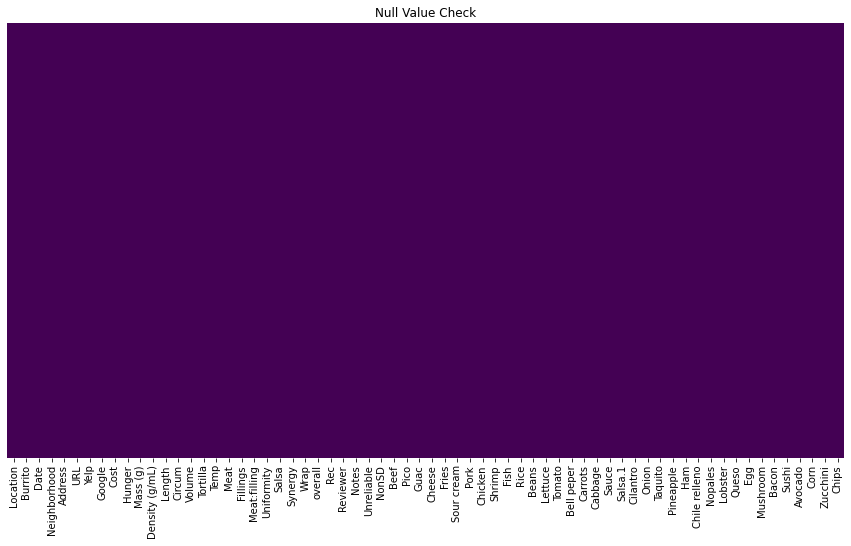

In [94]:
print('All null values are in yellow')
### Preapproval_Credit_Type is totally empty, it can be dropped from dataframe
### sequential horizontal yellow lines show that missing data in sequential columns, these record are analysed as below
plt.figure(figsize=(15,8))
sns.heatmap(data=df_master.isnull(), yticklabels=False, cbar= False, cmap='viridis')
plt.title('Null Value Check')

In [95]:
df_daily_cost = df_master.groupby('Date').agg({'Cost':['mean', 'std','sum'],
                                            'Burrito':'count',
                                            'Hunger':['mean', 'std','sum']})

df_daily_cost.columns = df_daily_cost.columns.droplevel(0)

df_daily_cost = df_daily_cost.reset_index().rename_axis(None, axis=1)
df_daily_cost.columns = ['date', 'Cost_mean', 'Cost_std', 'Cost_sum', 
                         'order_count', 'Hunger_mean', 'Hunger_std', 'Hunger_sum']

df_daily_cost.sort_values(by='date', ascending=True, inplace=True)

df_daily_cost[['Cost_mean', 'Hunger_mean']] = df_daily_cost[['Cost_mean', 'Hunger_mean']].fillna(value=0)

trace = go.Scatter(
    x = df_daily_cost['date'].values,
    y = df_daily_cost['Cost_mean'].values,
    mode='markers',
    marker=dict(
        size = df_daily_cost['Cost_mean'],
        color = df_daily_cost['Cost_mean'],
        colorscale='Portland',
        showscale=True
    )
)
layout= go.Layout(
    autosize= True,
    title= 'Daily mean order amount',
    hovermode= 'closest',
    xaxis=dict(
        title= 'Date',
        ticklen= 5,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Cost_mean',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=trace, layout=layout)
fig

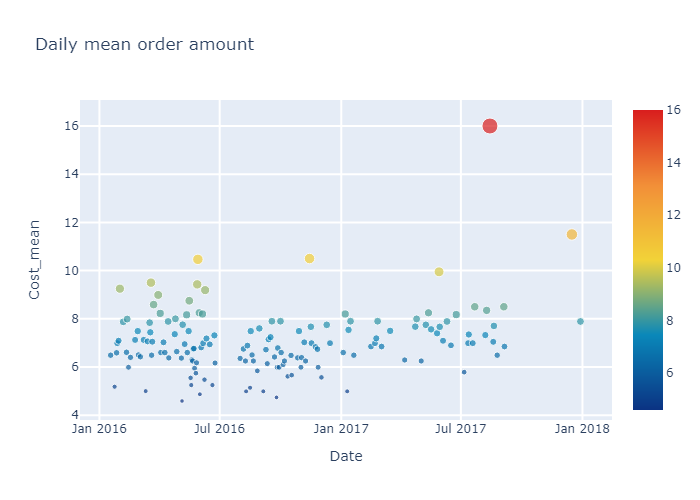

In [96]:
fig.show(renderer="png")